In [62]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import matplotlib.pyplot as plt
import Bio.PDB as pdb
from Bio.PDB import calc_angle, calc_dihedral
import lightgbm as lgbm
from keras.layers import Input, Dense, Flatten, Reshape
from keras.models import Model
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
import json
from sklearn.metrics import accuracy_score


In [63]:
from keras import layers
from keras import activations
from keras.models import load_model
import matplotlib.pyplot as plt

import seaborn as sns

In [64]:
import keras, keras.layers as L, keras.backend as K
from keras.utils import to_categorical
from keras.layers import Conv2D, BatchNormalization, Dropout, LeakyReLU, Dense, Conv1D, Activation, MaxPooling2D, MaxPooling1D
from keras.models import Sequential

In [65]:
amino_arr = ['ARG', 'LYS', 'GLN','GLU', 'MET', 'HIS', 'ILE','LEU', 'ASP', 'ASN', 'PHE', 'PRO', 'TRP', 'TYR', 'CYS', 'SER', 'THR', 'VAL']

In [66]:
def find_confidence_interval(data, confidence=0.95):
    n = data.shape[0]
    m = np.mean(data)
    std_err = np.std(data)
    h = (1 + confidence) * std_err

    return [m - h, m + h]

In [67]:
def getChiClass(amino, chi_x, angle, bounds):
    b = [-180] + bounds[amino][chi_x - 1]
    for i in range(len(b) - 1):
        if angle > b[i] and angle < b[i + 1]:
            return i
    return 0

In [68]:
def make_model_2d(a, b, num_classes):
    model = Sequential()
    num_layers = 4
    num_filters = 2
    
    for n in range(num_layers):
        if n == 0:
            model.add(Conv2D(filters= num_filters ,kernel_size=(4,4), input_shape=(a, b, 1), strides= (1, 1), padding='same'))
        else:
            model.add(Conv2D(filters= num_filters ,kernel_size=(4, 4), strides= (1, 1), padding='same'))
        model.add(BatchNormalization())
        model.add(LeakyReLU(alpha=0.2))
        num_filters *= 2

    model.add(Flatten())    
    model.add(Dense(num_classes))
    model.add(Activation("softmax"))
    return model

In [69]:
def make_model_coder(shape, code_size):    
    encoder = Sequential()
    encoder.add(L.InputLayer(shape))
    encoder.add(L.Dense(code_size))

    decoder = keras.models.Sequential()
    decoder.add(L.InputLayer((code_size,)))
    decoder.add(L.Dense(np.prod(shape))) # np.prod for 2d
    
    return encoder,decoder

In [70]:
def make_full_connected(a, num_classes):
    model = Sequential()
    model.add(Dense(128, input_shape=(a,)))
    model.add(layers.Activation(activations.relu))
    model.add(Dense(128, input_shape=(a,)))
    model.add(layers.Activation(activations.relu))
    model.add(Dense(128, input_shape=(a,)))
    model.add(layers.Activation(activations.relu))
    model.add(Dense(128, input_shape=(a,)))
    model.add(layers.Activation(activations.relu))
    model.add(Dense(num_classes))
    model.add(Activation("softmax"))
    return model

### 1. Построение доверительных интервалов, составление выборки из значений, входящих в доверительный интервал, сравнение с прошлыми результатами.

In [201]:
amino = 'THR'

In [202]:
train_data = pd.read_csv(amino + '_train_data.csv')
train_data = train_data.drop(columns=["Unnamed: 0", "pbd_indx"])
test_data = pd.read_csv(amino + '_test_data.csv')
test_data = test_data.drop(columns=["Unnamed: 0", "pbd_indx"])

path = 'chi_bounds.json'
with open(path, 'r') as f:
    bounds = json.loads(f.read())

count = 0
cols = train_data.columns.tolist()

for i in range(len(cols)):
    words = cols[i].split('_')
    if ('chi' in words):
        count += 1

for ind in range(count):
    train_data['chi_class_'+str(ind+1)] = train_data['chi_'+str(ind+1)].apply(lambda x:getChiClass(amino, ind+1, x, bounds))
    test_data['chi_class_'+str(ind+1)] = test_data['chi_'+str(ind+1)].apply(lambda x:getChiClass(amino, ind+1, x, bounds))




In [203]:
df = train_data[train_data['chi_class_1'] == 0] 
interval_1 = find_confidence_interval(((df['chi_1']  + 360) % 360).to_numpy())
df = train_data[train_data['chi_class_1'] == 1]
interval_2 = find_confidence_interval(((df['chi_1']  + 360) % 360).to_numpy())
df = train_data[train_data['chi_class_1'] == 2]
interval_3 = find_confidence_interval(((df['chi_1']  + 360) % 360).to_numpy())

In [204]:
train_data['chi_1'] = (train_data['chi_1'] + 360) % 360

tr_1 = train_data[train_data['chi_1'].between(interval_1[0], interval_1[1], inclusive=True)]

tr_2 = train_data[train_data['chi_1'].between(interval_2[0], interval_2[1], inclusive=True)]

tr_3 = train_data[train_data['chi_1'].between(interval_3[0], interval_3[1], inclusive=True)]

data_train = pd.DataFrame(tr_1)

data_train = data_train.append(tr_2)

data_train = data_train.append(tr_3)

In [205]:
test_data['chi_1'] = (test_data['chi_1'] + 360) % 360

tr_1 = test_data[test_data['chi_1'].between(interval_1[0], interval_1[1], inclusive=True)]

tr_2 = test_data[test_data['chi_1'].between(interval_2[0], interval_2[1], inclusive=True)]

tr_3 = test_data[test_data['chi_1'].between(interval_3[0], interval_3[1], inclusive=True)]

data_test = pd.DataFrame(tr_1)

data_test = data_test.append(tr_2)

data_test = data_test.append(tr_3)

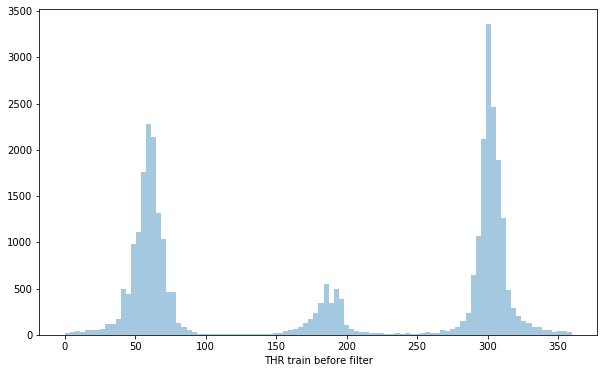

In [206]:
x = train_data['chi_1']
plt.figure(figsize=(10, 6))
sns.distplot(x, kde=False, bins=100)
plt.xlabel('THR train before filter')
plt.savefig('exp_1_THR')

Text(0.5, 0, 'THR train after filter')

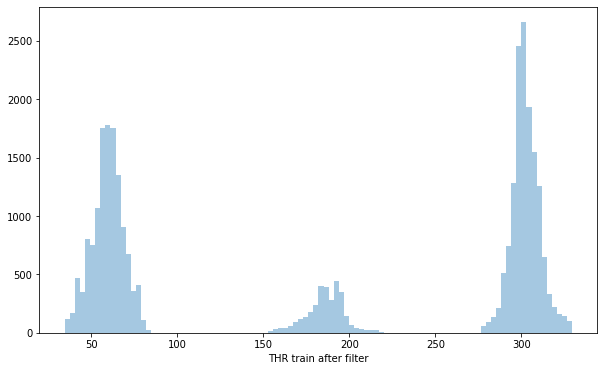

In [207]:
x = data_train['chi_1']
plt.figure(figsize=(10, 6))
sns.distplot(x, kde=False, bins=100)
plt.xlabel('THR train after filter')

Text(0.5, 0, 'THR test after filter')

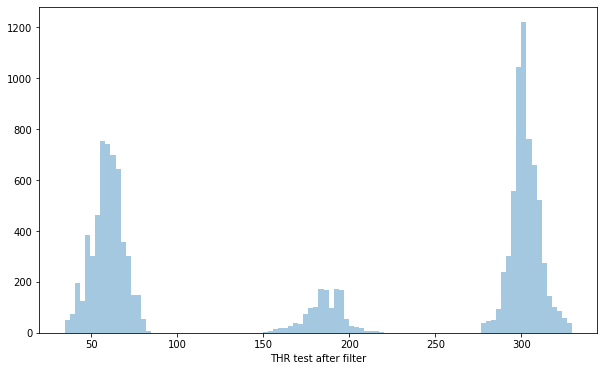

In [208]:
x = data_test['chi_1']
plt.figure(figsize=(10, 6))
sns.distplot(x, kde=False, bins=100)
plt.xlabel('THR test after filter')

In [209]:
train_data = data_train
test_data = data_test

In [210]:

chi_columns = ["chi_1", "chi_2", "chi_3", "chi_4", "chi_5"]
chi_col_list = ['chi_class_1', 'chi_class_2', 'chi_class_3', 'chi_class_4', 'chi_class_5']

train_data = train_data.drop(columns=chi_columns[:count])
test_data = test_data.drop(columns=chi_columns[:count])

y_train_list = []
y_test_list = []
for i in range(count):
    y_train_list.append(train_data[chi_col_list[i]])
    y_train_list[i] = np.array(y_train_list[i].values.tolist())
    y_test_list.append(test_data[chi_col_list[i]])
    y_test_list[i] = np.array(y_test_list[i].values.tolist())

train_data = train_data.drop(columns=chi_col_list[:count])
test_data = test_data.drop(columns=chi_col_list[:count])

categorical = list()
numeric = list()
column_array = list(train_data.columns)
for col in column_array:
    if type(train_data[col][0]) == str:
        categorical.append(col)
    else:
        numeric.append(col)

categorical_train = train_data[categorical]
one_hot_encoder = OneHotEncoder()
X_train_new = one_hot_encoder.fit_transform(categorical_train)
X_train_new = X_train_new.toarray()

categorical_test = test_data[categorical]
one_hot_encoder = OneHotEncoder()
X_test_new = one_hot_encoder.fit_transform(categorical_test)
X_test_new = X_test_new.toarray()

X_train_new_main = train_data.drop(columns=categorical)
X_test_new_main = test_data.drop(columns=categorical)

X_train_new_main = np.hstack((X_train_new_main.values, X_train_new))
X_test_new_main = np.hstack((X_test_new_main.values, X_test_new))

cols = ['True', 'LightGBM', 'CNN', 'AutoEncoder']
result_table = pd.DataFrame(columns=cols)


y_train = y_train_list[0]
y_test = y_test_list[0]

num_classes = np.unique(y_train).size

result_table['True'] = y_test

clf = lgbm.LGBMClassifier(n_estimators=2170, num_leaves = 88, max_depth = 16, min_child_samples = 1358, reg_alpha = 28.532, learning_rate = 0.26461, random_state = 42)
clf.fit(X_train_new_main, y_train)
predict = clf.predict(X_test_new_main)

result_table['LightGBM'] = predict



In [211]:
test_data = test_data.reset_index()

In [212]:
accuracy_score(y_test, predict)

0.8385464581416743

In [213]:
df = pd.read_csv(amino + '_chi_1.csv')

In [214]:
accuracy_score(df['True'], df['LightGBM'])

0.8191935250758781

Text(0.5, 0, 'THR wrong predictions for LightGBM')

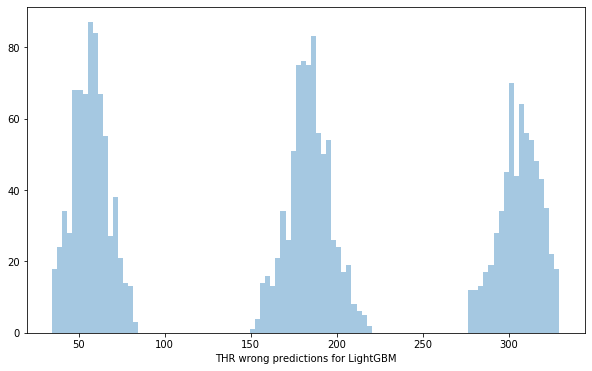

In [215]:
x = (data_test.loc[predict != y_test]['chi_1'] + 360) % 360
plt.figure(figsize=(10, 6))
sns.distplot(x, kde=False, bins=100)
plt.xlabel('THR wrong predictions for LightGBM')